# Telco Churn Prediction

In [1]:
import numpy as np
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
import pickle

sns.set()

%matplotlib inline

In [2]:
# If you need to download the data
import opendatasets as od
od.download('https://www.kaggle.com/datasets/blastchar/telco-customer-churn')

Skipping, found downloaded files in "./telco-customer-churn" (use force=True to force download)


## Data Prep

In [3]:
def get_data(file):
    return pd.read_csv(file)

def lower_case(df):
    df.columns = df.columns.str.lower()
    return df

def get_formatted_data(file):
    return lower_case(get_data(file))

In [4]:
df = get_formatted_data('churn_data/churn.csv')
df.head()

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
def plot_histograms(df, variables: list):
    # Roughly set # rows and columns of axes based on # of plots
    if len(variables) <= 2:
        nrows=1
    elif len(variables) <= 6:
        nrows=2
    elif len(variables) <= 9:
        nrows=3
    else:
        nrows=4
    ncols = math.ceil(len(variables) / nrows)
    # Roughly set fig size
    if nrows >= 3:
        figsize = (14, 14)
    elif nrows >= 2:
        figsize = (14, 11)
    else:
        figsize = (14, 8)
    # Plot variables
    fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize = figsize)
    ax = ax.flatten()
    fig.suptitle('Distributions of IV\'s', fontsize = 32)
    for i in range(len(variables)):
        title = variables[i].replace('_', ' ').title()
        sns.histplot(df[variables[i]], bins=80, color='blue', ax=ax[i]).set(title=title)
    plt.tight_layout()

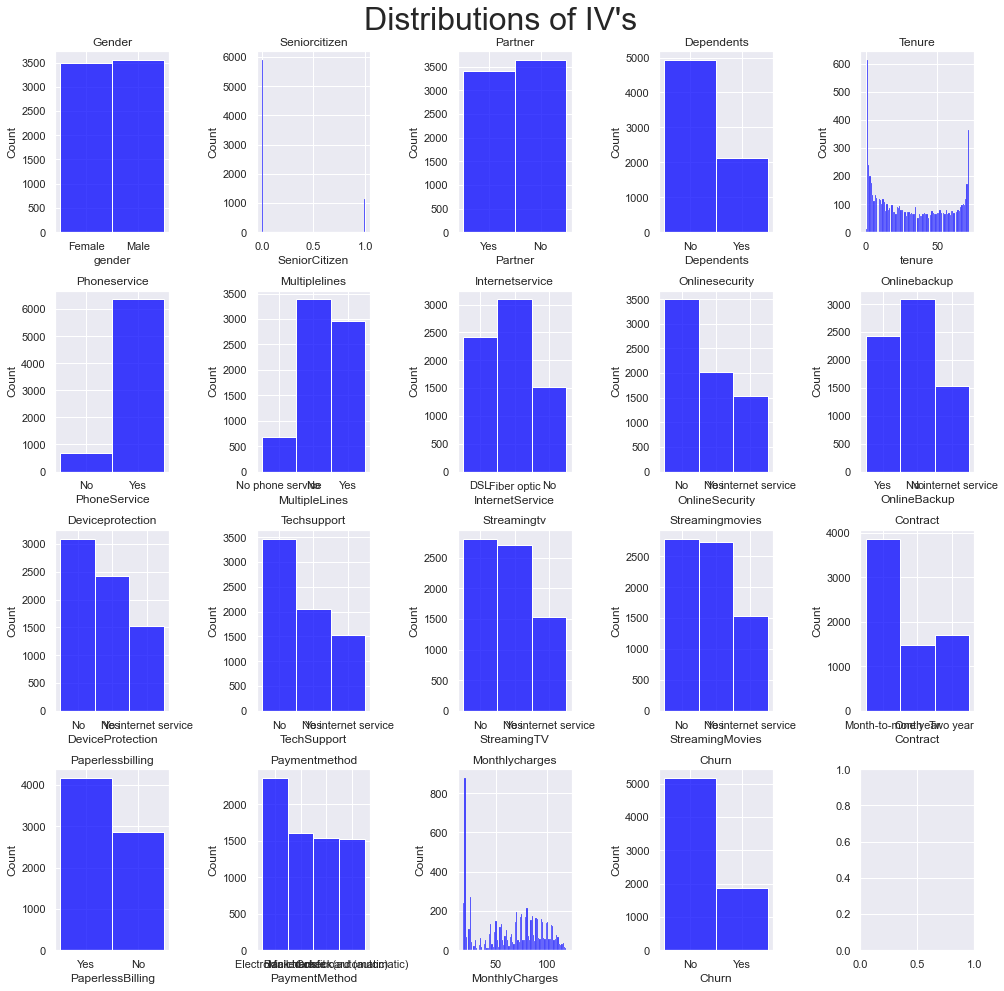

In [6]:
df = get_data('churn_data/churn.csv')
plot_histograms(df, ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
                   'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
                   'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                   'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
                   'PaymentMethod', 'MonthlyCharges', 'Churn'])

To-do List:

1. Most of these variables are categorical, and with the exception of **seniorcitizen**, they need to be turned into dummy variables or one-hot vectors. 

2. **totalcharges**, even though numeric, is coded with strings. Hence we need to force **totalcharges** to float.

3. The DV, **churn**, needs to be numeric.

#### Force *totalcharges* to Numeric

In [7]:
# Reimport data
df = get_formatted_data('churn_data/churn.csv')

df['totalcharges'] = pd.to_numeric(df['totalcharges'], errors='coerce')
# Removing entries with no values
df = df[df['totalcharges'].isnull()==False]

#### Make DV Numeric

In [8]:
df['churn'] = (df['churn']=='Yes') * 1

#### Transform Categoricals to One-hot Vectors

In [9]:
features = ['gender', 'seniorcitizen', 'partner', 'dependents',
           'tenure', 'phoneservice', 'multiplelines', 'internetservice',
           'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
           'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
           'paymentmethod', 'monthlycharges', 'totalcharges']
# Partitioning Data into Train and Test Sets
n = len(df)
index = np.arange(0, n)
rng = np.random.default_rng()
rng.shuffle(index)
df_train = df.iloc[index[0: 4 * n // 5]]
df_test = df.iloc[index[4 * n // 5:]]

In [23]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[features].to_dict(orient='records')
test_dict = df_test[features].to_dict(orient='records')
dv.fit(train_dict)
X_train = dv.transform(train_dict)
dv.fit(test_dict)
X_test = dv.transform(test_dict)

### Logistic Model

In [24]:
logit = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000, random_state=42)
logit.fit(X_train, df_train['churn'].values)

LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

In [25]:
coefficients = pd.DataFrame()
coefficients['features'] = dv.get_feature_names_out()
coefficients['coefficients'] = logit.coef_.squeeze()
coefficients

,features,coefficients
0,contract=Month-to-month,0.533587
1,contract=One year,-0.102290
2,contract=Two year,-0.567356
3,dependents=No,0.014454
4,dependents=Yes,-0.150513
5,deviceprotection=No,-0.012104
6,deviceprotection=No internet service,-0.111044
7,deviceprotection=Yes,-0.012911
8,gender=Female,-0.063423
9,gender=Male,-0.072636


### Evaluate Model

In [26]:
def cutoff_preds(cutoffs: list, model, x: np.ndarray, y: np.ndarray):
    predictions = pd.DataFrame()
    predictions['target'] = y
    if model.predict_proba(x).shape[1] > 1:
        predictions['probs'] = model.predict_proba(x)[:,1] 
    else:
        predictions['probs'] = model.predict_proba(x) 
    cutoff_dict = {cutoff: (predictions['probs'] > cutoff) * 1 \
                   for cutoff in cutoffs}
    cutoff_df = pd.DataFrame(cutoff_dict)
    cutoff_df = pd.concat([predictions, cutoff_df], axis=1)
    return cutoff_df
        
def cutoff_acc(cutoffs: list, model, x: np.ndarray, y: np.ndarray):
    predictions = cutoff_preds(cutoffs, model, x, y)
    acc_list = [(predictions[cutoff]==predictions['target']).sum() \
                /len(predictions) for cutoff in cutoffs]
    return acc_list

def false_neg(cutoffs: list, model, x: np.ndarray, y: np.ndarray):
    predictions = cutoff_preds(cutoffs, model, x, y)
    false_negs = [((predictions[cutoff]!=predictions['target']) \
                   & (predictions['target']==1)).sum()
                /len(predictions) for cutoff in cutoffs]
    return false_negs

def false_pos(cutoffs: list, model, x: np.ndarray, y: np.ndarray):
    predictions = cutoff_preds(cutoffs, model, x, y)
    false_pos = [((predictions[cutoff]!=predictions['target']) & \
                  (predictions['target']==0)).sum()
                /len(predictions) for cutoff in cutoffs]
    return false_pos

def true_pos(cutoffs: list, model, x: np.ndarray, y: np.ndarray):
    predictions = cutoff_preds(cutoffs, model, x, y)
    true_pos = [((predictions[cutoff]==predictions['target']) & \
                 (predictions['target']==1)).sum()
                /len(predictions) for cutoff in cutoffs]
    return true_pos

def true_neg(cutoffs: list, model, x: np.ndarray, y: np.ndarray):
    predictions = cutoff_preds(cutoffs, model, x, y)
    true_negs = [((predictions[cutoff]==predictions['target']) & \
                  (predictions['target']==0)).sum()
                /len(predictions) for cutoff in cutoffs]
    return true_negs

def precision(cutoffs: list, model, x: np.ndarray, y: np.ndarray):
    predictions = cutoff_preds(cutoffs, model, x, y)
    precision_list = [((predictions[cutoff]==predictions['target']) & \
                       (predictions['target']==1)).sum()
                /(predictions[cutoff]==1).sum() for cutoff in cutoffs]
    return precision_list

def recall(cutoffs: list, model, x: np.ndarray, y: np.ndarray):
    predictions = cutoff_preds(cutoffs, model, x, y)
    recall_list = [((predictions[cutoff]==predictions['target']) & \
                    (predictions['target']==1)).sum()
                /(predictions['target']==1).sum() for cutoff in cutoffs]
    return recall_list

def FPR(cutoffs: list, model, x: np.ndarray, y: np.ndarray):
    predictions = cutoff_preds(cutoffs, model, x, y)
    fpr_list = [((predictions[cutoff]!=predictions['target']) & \
                 (predictions['target']==0)).sum()
                /(predictions['target']==0).sum() for cutoff in cutoffs]
    return fpr_list

In [27]:
def plot_eval_metrics(model):
    cutoffs = np.linspace(-.001, 1, 100)
    acc_list = cutoff_acc(cutoffs, model, X_test, df_test['churn'].values)

    false_negs = false_neg(cutoffs, model, X_test, df_test['churn'].values)
    false_positives = false_pos(cutoffs, model, X_test, df_test['churn'].values)
    true_negs = true_neg(cutoffs, model, X_test, df_test['churn'].values)
    true_positives = true_pos(cutoffs, model, X_test, df_test['churn'].values)

    precision_list = precision(cutoffs, model, X_test, df_test['churn'].values)
    recall_list = recall(cutoffs, model, X_test, df_test['churn'].values)

    FPR_list = FPR(cutoffs, model, X_test, df_test['churn'].values)
    if model.predict_proba(X_test).shape[1] > 1:
        scores = model.predict_proba(X_test)[:,1]
    else:
        scores = model.predict_proba(X_test)

    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
    ax = ax.flatten()
    sns.lineplot(x=cutoffs, y=acc_list, ax=ax[0])
    ax[0].set_xlabel('Cutoff')
    ax[0].set_title('Accuracy for Different Cutoffs')
    ax[0].set_ylabel('Accuracy')

    sns.lineplot(x=cutoffs, y=false_negs, label='FN', ax=ax[1])
    sns.lineplot(x=cutoffs, y=false_positives, label='FP', ax=ax[1])
    sns.lineplot(x=cutoffs, y=true_positives, label='TP', ax=ax[1])
    sns.lineplot(x=cutoffs, y=true_negs, label='TN', ax=ax[1])
    ax[1].set_xlabel('Cutoff')
    ax[1].set_title('True/False Neg/Pos Rate for Different Cutoffs')
    ax[1].set_ylabel('Fraction of samples')

    sns.lineplot(x=cutoffs, y=precision_list, label='Precision', ax=ax[2])
    sns.lineplot(x=cutoffs, y=recall_list, label='Recall', ax=ax[2])
    ax[2].set_xlabel('Cutoff')
    ax[2].set_title('Precision and Recall for Different Cutoffs')

    sns.lineplot(x=cutoffs, y=FPR_list, label='FPR', ax=ax[3])
    sns.lineplot(x=cutoffs, y=recall_list, label='Recall', ax=ax[3])
    ax[3].set_xlabel('Cutoff')
    ax[3].set_title('FPR and Recall')

    from sklearn.metrics import auc
    sns.lineplot(x=FPR_list, y=recall_list, ax=ax[4])
    ax[4].set_xlabel('FPR')
    ax[4].set_ylabel('TPR')
    ax[4].set_title(f'ROC - Area under ROC Curve: {auc(FPR_list, recall_list):.3f}')

    sns.histplot(scores, bins=40, color='blue', ax=ax[5])
    ax[5].set_title('Distribution of Scores')

    plt.suptitle('Eval Metrics', fontsize=32)
    plt.tight_layout()

<ipython-input-26-3d785bf1ff5a>:50: RuntimeWarning: invalid value encountered in long_scalars
  precision_list = [((predictions[cutoff]==predictions['target']) & \


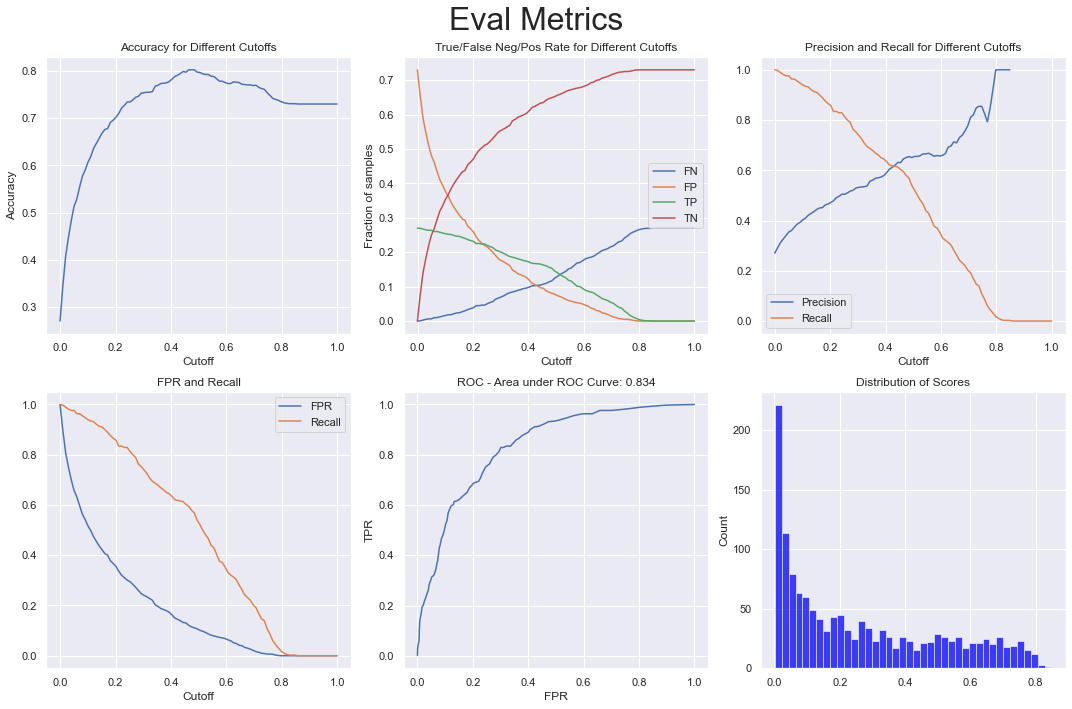

In [28]:
plot_eval_metrics(logit)

### Save Model

In [31]:
file_name = 'logit_model'
with open(file_name, 'wb') as file:
    pickle.dump((dv, logit), file)

## MLP Model

In [32]:
import torch.nn as nn

class Model(torch.nn.Module):
    def __init__(self, nodes):
        super().__init__()
        self.lin1 = nn.Linear(45, nodes)
        self.lin2 = nn.Linear(nodes, nodes)
        self.lin3 = nn.Linear(nodes, 30)
        self.lin4 = nn.Linear(30, 1)
        self.act = nn.ReLU()
        self.sig = nn.Sigmoid()
        self.drop = nn.Dropout(.4)
    def forward(self, x):
        x = self.lin1(x)
        x = x * self.sig(x)
        x = self.drop(x)
        x = self.lin2(x)
        x = x * self.sig(x)
        x = self.drop(x)
        x = self.lin3(x)
        x = x * self.sig(x)
        x = self.drop(x)
        return self.lin4(x)
    def predict_proba(self, x):
        '''For use with the plot_eval_metrics function and its sub functions'''
        x = torch.from_numpy(x).type(torch.float32)
        probs = self.sig(self.lin4(self.act(self.lin3(self.act(self.lin2(self.act(self.lin1(x))))))))
        return probs.detach().numpy()

class SmallModel(torch.nn.Module):
    def __init__(self, nodes):
        super().__init__()
        self.lin1 = nn.Linear(45, 1)
        self.sig = nn.Sigmoid()
    def forward(self, x):
        return self.lin1(x)
    def predict_proba(self, x):
        '''For use with the plot_eval_metrics function and its sub functions'''
        x = torch.from_numpy(x).type(torch.float32)
        probs = self.sig(self.forward(x))
        return probs.detach().numpy()

def train_epoch(model, batches, target, optimizer, device, criterion):
    running_loss = 0
    for i, batch in enumerate(batches):
        batch = batch.to(device)
        pred = model(batch).squeeze()
        loss = criterion(pred, target[i].to(device))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        running_loss += loss.item()
    return running_loss

def evaluate(model, batches, target, device, criterion):
    running_loss = 0
    for i, batch in enumerate(batches):
        batch = batch.to(device)
        pred = model(batch).squeeze()
        loss = criterion(pred, target[i].to(device))
        running_loss += loss.item()
    return running_loss

def batchify(data, batch_size):
    num_batches = data.shape[0] // batch_size
    batch_list = [data[batch_size * i: batch_size * (i + 1)] for i in range(num_batches)]
    return batch_list

In [33]:
def train(model, optimizer, num_epochs, X_train, Y_train, batch_size, device='cpu', new_lr=None):
    batch_size = 64
    criterion = nn.BCEWithLogitsLoss()
    if new_lr is not None:
        for param_group in optimizer.param_groups:
            param_group['lr'] = new_lr

    train_data = torch.from_numpy(X_train).type(torch.float32)
    train_targets = torch.from_numpy(Y_train).type(torch.float32)
    
    train_batches = batchify(train_data, batch_size)
    train_targ_batches = batchify(train_targets, batch_size)
    
    test_data = torch.from_numpy(X_test).type(torch.float32)
    test_targets = torch.from_numpy(Y_test).type(torch.float32)
    
    test_batches = batchify(test_data, batch_size)
    test_targ_batches = batchify(test_targets, batch_size)
    
    for i in range(num_epochs):
        epoch_loss = train_epoch(model, train_batches, train_targ_batches, optimizer, device, criterion)
        eval_loss = evaluate(model, test_batches, test_targ_batches, device, criterion)
        if i % 50 == 0:
            print(f'epoch {i} | train loss: {epoch_loss:.2f} | test loss: {eval_loss:.3f}')

In [34]:
n = len(df)
index = np.arange(0, n)
rng = np.random.default_rng()
rng.shuffle(index)
df_train = df.iloc[index[0: 4* n // 5]]
df_test = df.iloc[index[4 * n // 5:]]
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

dv = DictVectorizer(sparse=False)
train_dict = df_train[features].to_dict(orient='records')
test_dict = df_test[features].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)
Y_train = df_train['churn'].values
X_test = dv.fit_transform(test_dict)
Y_test = df_test['churn'].values

mlp = Model(600).to('cpu')
optimizer = torch.optim.Adam(params=mlp.parameters(), lr=0.0001)

In [35]:
mlp.train()
train(mlp, optimizer, 500, X_train, Y_train, batch_size=512, device='cpu', new_lr=0.0001)

epoch 0 | train loss: 154.84 | test loss: 16.346
epoch 50 | train loss: 47.69 | test loss: 12.159
epoch 100 | train loss: 41.53 | test loss: 10.449
epoch 150 | train loss: 39.01 | test loss: 9.983
epoch 200 | train loss: 37.77 | test loss: 9.654
epoch 250 | train loss: 36.71 | test loss: 9.632
epoch 300 | train loss: 36.47 | test loss: 9.701
epoch 350 | train loss: 35.63 | test loss: 9.583
epoch 400 | train loss: 34.99 | test loss: 9.537
epoch 450 | train loss: 34.55 | test loss: 9.677


<ipython-input-26-3d785bf1ff5a>:50: RuntimeWarning: invalid value encountered in long_scalars
  precision_list = [((predictions[cutoff]==predictions['target']) & \


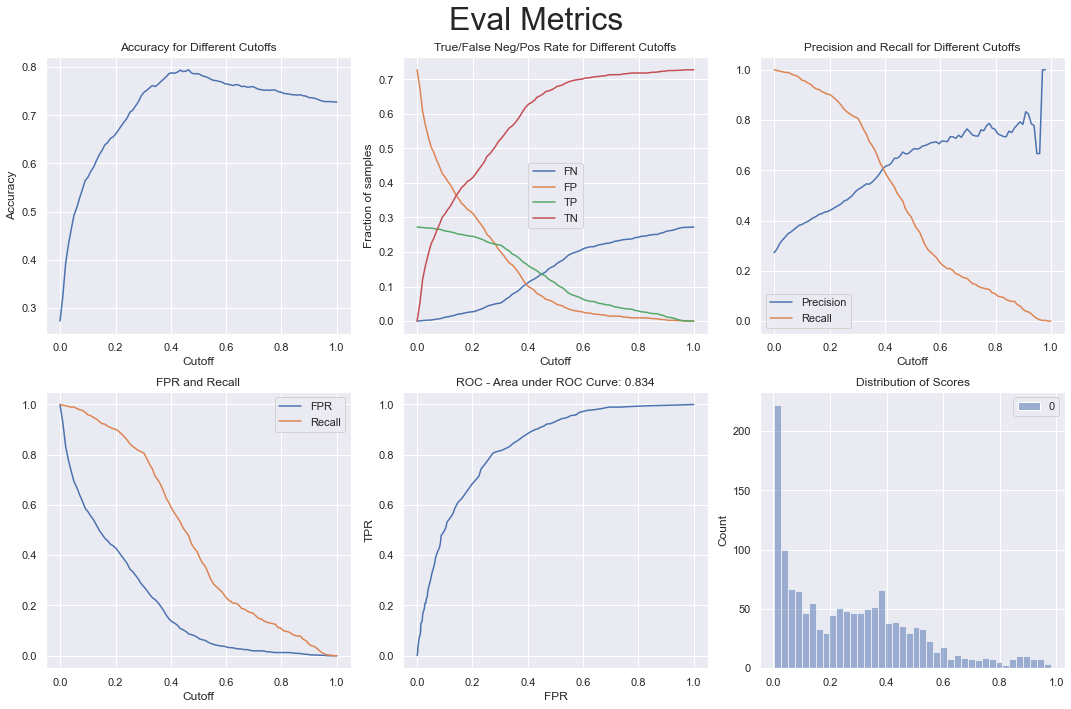

In [36]:
mlp.eval()
plot_eval_metrics(mlp)

### Save Model

In [37]:
file_name = 'mlp_model'
with open(file_name, 'wb') as file:
    pickle.dump((dv, mlp), file)

## Which Model is Better, and What Should Our Prediction Rule Be?

There are four cases to consider:

1. A customer who is about to churn receives an offer from marketing (True Positive)
2. A customer who is about to churn doesn't receive an offer from marketing (False Negative)
3. A customer who isn't about to churn receives an offer from marketing (False Positive)
4. A customer who isn't about to churn doesn't receive an offer form marketing(True Negative)

Suppose, to simplify matters, that we are considering a one year time horizon. Let's imagine as well that the following is true. 

If a customer is about to churn, their probability of churning over the next year decreases from $1.0$ to $P(\mathit{Churn} \mid \mathit{Offer})$ when they are given an offer. The cash value over the year of giving the customer that offer is therefore 
$(1 - P(\mathit{Churn} \mid \mathit{Offer})) \times 12 \times (\mathit{OfferPrice} - \mathit{PlanCost})$. If that customer doesn't receive an offer, then they immediately leave, and the cash value over the year of not giving the customer the offer is 0. The relative value over the year of giving a customer about to leave an offer is then

\begin{equation}
\tag{1}
    Val = 12 \times (1 - P(\mathit{Churn} \mid \mathit{Offer})) \times (\mathit{OfferPrice} - \mathit{PlanCost})
\end{equation}


If a customer is not about to churn, then their value over the year is $12 \times \mathit{NormalPrice} - 12 \times \mathit{PlanCost}$. If that customer receives an offer, then their value over the year is $12 \times \mathit{OfferPrice} - 12 \times \mathit{PlanCost}$. The relative value over the year of giving a customer who won't leave anyway is 

\begin{equation}
\tag{2}
    Val = -12 \times (\mathit{NormalPrice} - \mathit{OfferPrice}). 
\end{equation}


Thus, for every True Positive, yearly profit increases by equation 1, and for every False Positive, yearly profit decreases by equation 2. It then seems sensible to determine for each model which decision rule, or which cutoff point, optimizes profits (given this admittedly simple model). The main work to do here is maximizing

\begin{equation}
\tag{3}
    \mathit{Profit}(TP, FP) = TP \times ( 1 - P(\mathit{Churn} \mid \mathit{Offer})) \times (\mathit{OfferPrice}_{P} - \mathit{PlanCost}_{P}) - FP \times (\mathit{NormalPrice}_{N} - \mathit{OfferPrice}_{N})
\end{equation}

subject to the constraints for TP and FP given by the models. In other words, we are maximizing the following on Cutoff:

\begin{equation}
\tag{4}
    \mathit{Profit}(\mathit{Cutoff}) = TP(\mathit{Cutoff}) \times ( 1 - P(\mathit{Churn} \mid \mathit{Offer})) \times (\mathit{OfferPrice}_{P} - \mathit{PlanCost}_{P}) - FP(\mathit{Cutoff}) \times (\mathit{NormalPrice}_{N} - \mathit{OfferPrice}_{N}).
\end{equation}

Since Since Normal Price and Offer Price are dependent on Churning (Both Churn and prediction are correlated with Monthly Price, and Offer Prices will presumably be correlated with Normal Prices, since they will likely take the form of dollar amount monthly discounts or percentage discounts), I've given them distinct variables. In both true positive and false positive cases, the relationship between NormalPrice and OfferPrice is

\begin{equation}
    \mathit{OfferPrice} = f(\mathit{NormalPrice})
\end{equation}

Since $TP(\mathit{Cutoff})$ isn't differentiable, and since Cutoff is only one variable, instead of approximating $TP(\mathit{Cutoff})$ with a polynomial function, I'm just going to numerically determine the maximum, given different values for the effect of a discount on churn, the size of the discount, and the cost of serving the customer's plan. 

In [709]:
cutoffs = np.linspace(0, 1, 101)

def get_profits(cutoffs, model, df, x, y, discount_churn_prob, discount_factor, plan_cost_factor):
    predictions = cutoff_preds(cutoffs, model, x, y)
    big_df = pd.concat([df, predictions], axis=1)
    
    false_pos = [(cutoff, ((predictions[cutoff]!=predictions['target']) & \
                  (predictions['target']==0))) for cutoff in cutoffs]
    false_pos_dict = {str(cutoff) + '_false_pos': series for cutoff, series in false_pos}
    false_df = pd.DataFrame(false_pos_dict)
    
    true_pos = [(cutoff, ((predictions[cutoff]==predictions['target']) & \
                  (predictions['target']==1))) for cutoff in cutoffs]
    true_pos_dict = {str(cutoff) + '_true_pos': series for cutoff, series in true_pos}
    true_df = pd.DataFrame(true_pos_dict)
    big_df = pd.concat([big_df, false_df, true_df], axis=1)
    
    relative_profit = []
   
    for cutoff in cutoffs:
        true_positives = big_df.loc[big_df[str(cutoff) + '_true_pos']]
        monthly_charges = true_positives['monthlycharges']
        discount_charges = discount_factor * monthly_charges
        plan_cost = plan_cost_factor * monthly_charges
        expected_profit = (1 - discount_churn_prob) * (discount_charges - plan_cost).values.sum()
        
   
        false_positives = big_df.loc[big_df[str(cutoff) + '_false_pos']]
        monthly_charges = false_positives['monthlycharges']
        discount_charges = discount_factor * monthly_charges
        expected_loss = (monthly_charges - discount_charges).values.sum()
        
        relative_profit.append(expected_profit - expected_loss)
    return relative_profit

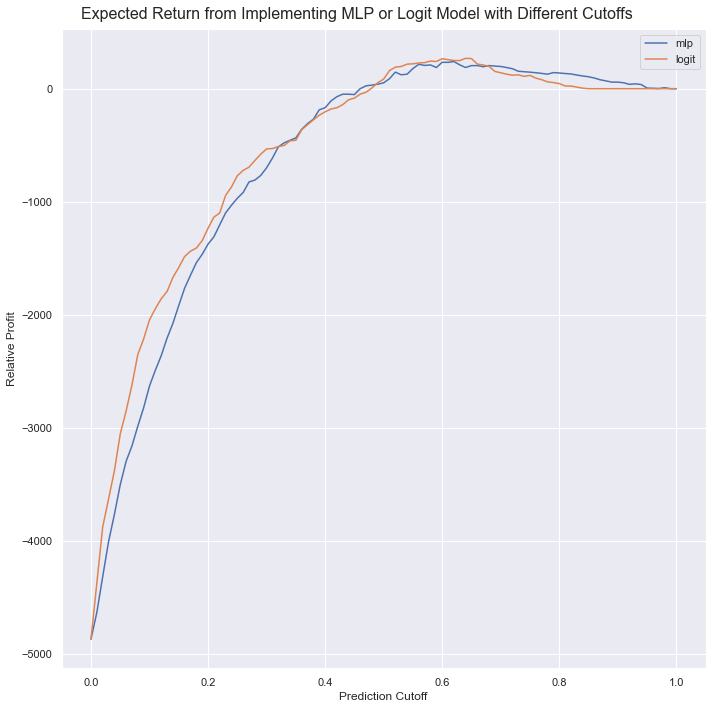

In [830]:
mlp_profit = get_profits(cutoffs, mlp, df_test, X_test, Y_test, .5, .9, .8)
logit_profit = get_profits(cutoffs, logit, df_test, X_test, Y_test, .5, .9, .8)
fig, ax = plt.subplots(figsize=(10,10))
sns.lineplot(x=cutoffs, y=mlp_profit, label='mlp', ax=ax).set_xlabel('Prediction Cutoff')
sns.lineplot(x=cutoffs, y=logit_profit, label='logit', ax=ax).set_ylabel('Relative Profit')
plt.suptitle('Expected Return from Implementing MLP or Logit Model with Different Cutoffs', fontsize=16)
plt.tight_layout()

As playing around with the numbers above suggests, especially if plan_cost_factor is set conservatively between .7 and .9, the relative profit of the discount intervention is slim, whether the model is the logit model or the mlp model. Nevertheless, it might help to improve our model by estimating the relationship between the posterior probability of churning and the size of a discount. If we did this, then we'be able to reduce the dimensions of the space we're searching for relative profit in by 1 dimension. We could do this by using the logit model's estimate of each customer's probability of leaving if their monthly charges are reduced by some factor. However, the logit model likely underestimates the effect of discounts severely, especially for sizable discounts. At the extreme, the logit model estimates that a discount to $0 per month will on average reduce churn probability by less than 10\%. This is of course hard to believe. Hence, I'm going to leave this here. 

As for what could be done to improve our evaluation of the two models, there are two clear steps:

1. We would need to get data on the effects of discounts on churn. Data generated by randomly assigning discounts would give the models more information about the relationship between monthly charges and churn probability, and would in particular make the models better at estimating the effects of large changes in monthly charges. 

2. We would need to model the churn process so that, if we knew a customer's probability of churning in the next year, we could also estimate that customer's probability of churning in each month of the next year, conditional on his not having churned yet. This would allow us to more sensibly estimate the expected return from sending out discounts. As things stand now, our model assumes that customers who receive a discount either churn immediately anyways or stay on for the course of a year. 